In [21]:
import argparse
import itertools
import os.path
import time

import torch
import torch.optim.lr_scheduler
import torch.nn as nn
import numpy as np
from pathlib import Path

import evaluate
import trees
import vocabulary
import nkutil
import parse_nk
import csv
import matplotlib.pyplot as plt
import random
import pdb

In [15]:
temp = torch.load(str(Path(os.getcwd()).parent) + "\\Data\\en_charlstm_dev.93.61.pt")
parser = parse_nk.NKChartParser.from_spec(temp['spec'], temp['state_dict'])
if 'UNK' in parser.tag_vocab.indices:
    dummy_tag = 'UNK'
else:
    dummy_tag = parser.tag_vocab.value(0)

In [3]:
def process_sequences(seq_batch):
    outputs_0= []
    def hook_0(module, input, output):
        outputs_0.append(output)
    outputs_1 = []
    def hook_1(module, input, output):
        outputs_1.append(output)
    outputs_2 = []
    def hook_2(module, input, output):
        outputs_2.append(output)
    outputs_3 = []
    def hook_3(module, input, output):
        outputs_3.append(output)
    outputs_4 = []
    def hook_4(module, input, output):
        outputs_4.append(output)
    outputs_5 = []
    def hook_5(module, input, output):
        outputs_5.append(output)
    outputs_6 = []
    def hook_6(module, input, output):
        outputs_6.append(output)
    outputs_7 = []
    def hook_7(module, input, output):
        outputs_7.append(output)



    #original model = parser
    #parser.char_encoder.lstm.register_forward_hook(hook)
    #parser.f_label[3].register_forward_hook(hook)
    #parser.encoder.ff_0.layer_norm.register_forward_hook(hook_0)
    parser.encoder.ff_1.layer_norm.register_forward_hook(hook_0)
    parser.encoder.ff_1.layer_norm.register_forward_hook(hook_1)
    parser.encoder.ff_2.layer_norm.register_forward_hook(hook_2)
    parser.encoder.ff_3.layer_norm.register_forward_hook(hook_3)
    parser.encoder.ff_4.layer_norm.register_forward_hook(hook_4)
    parser.encoder.ff_5.layer_norm.register_forward_hook(hook_5)
    parser.encoder.ff_6.layer_norm.register_forward_hook(hook_6)
    parser.encoder.ff_7.layer_norm.register_forward_hook(hook_7)
    out, _ = parser.parse_batch(seq_batch)
    del _

    temp_acts = outputs_0[0].numpy() + outputs_1[0].numpy() + outputs_2[0].numpy() + outputs_3[0].numpy() + \
        outputs_4[0].numpy() + outputs_5[0].numpy() + outputs_6[0].numpy() + outputs_7[0].numpy()
    # drop first and last one
    temp_acts = temp_acts[1:-1,:]
    return temp_acts


In [12]:
# power spectra function
def power_spectra(w2vec_array, sampling_rate=16):
    """Computes power spectra using the Discrete Fourier Transform.

    Args:
        w2vec_array: arrays of shape (n_sentences*time_steps, n_units)
            representing hidden layer activations in response to each word of the
            concatenated sequence of sentences.
        sample_rate: number of measures (outputs of the model) per second.

    Returns:
        Mean power spectra and frequency axis.
    """

    # Separate each unit and concatenate across words to form 1 vector per unit
    unit_vectors = np.transpose(w2vec_array)

    # Frequency domain
    # num_samples is just the number of data points for each unit
    num_samples = unit_vectors.shape[1]
    freq = np.fft.rfftfreq(num_samples, d=1./sampling_rate)
    #print ('freq ' ,freq.shape)
    # Calculate the FFT and power spectra for each unit
    units_ps = []
    for vector in unit_vectors:
        ft_unit = np.fft.rfft(vector)  # fft
        ps_uni = np.abs(ft_unit) ** 2  # power spectrum
        units_ps.append(ps_uni)

    # Average power spectra over units
    units_ps = np.array(units_ps)
    mean_ps = np.mean(units_ps, axis=0)
    #print ('mean_ps',mean_ps.shape)
    return freq, mean_ps, units_ps

In [13]:
def plot_results(plot_path, freq, power,sampling_rate=200,n_samples=60,title='Input stimuli',smoothed=True):
    """Plot all the results of one condition"""
    plt.rcParams['pdf.fonttype'] = 42 # for the eps files
    plt.rcParams['ps.fonttype'] = 42

    # Time domain parameters
    sampling_interval = 1.0/sampling_rate  # sampling interval
    # Build plot
    plt.title(title)
    #hz_4 = np.where(freq == 4)[0][0]
    plt.plot(freq, power, 'r', linewidth=1.0)
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Power (db)')
    # Adjusts subplot
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save
    #plt.plot()
    plt.savefig(plot_path+'.pdf')
    plt.pause(0.05)

    return


In [6]:
def create_sentences(SenType = 'sen'):
    # possible sentypes: 
    # sen:          regular sentence
    # wordlist:     wordlists
    # nongrammar:   grammatically correct, nonsensical
    # nounphrase:   noun phrases
    # verbphrase:   verb phrases
    # random:       adjective noun verb noun random
    
    # Load dictionaries
    base = str(Path(os.getcwd()).parent)
    new_dict = np.load(base + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0] # create 3 different orthogonal vecs to encode gaps,
    new_dict.item()['ENDW'] = np.eye(new_dict.item()['cute'].shape[0])[1] # endw, ends
    new_dict.item()['ENDS'] = np.eye(new_dict.item()['cute'].shape[0])[2]
    
    with open(base + '\\Data\\Ding_grammatical.csv', 'r') as f:
        all_sentences = [row for row in csv.reader(f)]
    nouns, adjectives, verbs = [],[],[]
    for sentence in all_sentences:
        nouns.append(sentence[1])
        nouns.append(sentence[3])
        adjectives.append(sentence[0])
        verbs.append(sentence[2])
    nouns = list(set(nouns))
    adjectives = list(set(adjectives))
    verbs = list(set(verbs))
    all_words = nouns + adjectives + verbs


    N = 60        
    if SenType == 'sen':
        # Load words as lists
        with open(base + '\\Data\\Ding_grammatical.csv', 'r') as f:
            sentence_list = [row for row in csv.reader(f)]
            
    elif SenType == 'wordlist':
        sentence_list = [random.sample(all_words,4) for i in range(N)]
        
    elif SenType == 'nongrammar':   
        sentence_list = list()
        for i in range(N):
            w1 = random.sample(adjectives,1)[0]
            w2 = random.sample(nouns,1)[0]
            w3 = random.sample(verbs,1)[0]
            w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'nounphrase':        
        sentence_list = list()
        for i in range(N):
            w1 = random.sample(adjectives,1)[0]
            w2 = random.sample(nouns,1)[0]
            w3 = random.sample(adjectives,1)[0]
            w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'verbphrase':
        sentence_list = list()
        for i in range(N):
            w1 = random.sample(verbs,1)[0]
            w2 = random.sample(nouns,1)[0]
            w3 = random.sample(verbs,1)[0]
            w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'random':
        sentence_list = list()
        for i in range(N):
            w1 = random.sample(verbs,1)[0]
            w2 = random.sample(nouns,1)[0]
            w3 = random.sample(nouns,1)[0]
            w4 = random.sample(adjectives,1)[0]
            sentence_list.append([w1,w2,w3,w4])   
    # add these pseudo words to all_words now because they only need to appear in repn, not in sequence info itself
    all_words.append('NONE')
    all_words.append('ENDW')
    all_words.append('ENDS')
    embedding_dict = {}
    one_hot_dict = {}
    for ind,key in enumerate(all_words):
        embedding_dict[key] = new_dict.item()[key]
        one_hot_dict[key] = np.eye(len(all_words))[ind]
    return sentence_list, embedding_dict, one_hot_dict

In [7]:
def gen_data_matrix(seq_type = 'sen'):
    all_sequences,_,_ = create_sentences(SenType=seq_type)
    random.shuffle(all_sequences)
    all_samples = []
    for i in range(20):
        current_sample = random.sample(all_sequences,13)
        current_sample = [word for seq in current_sample for word in seq]
        all_samples.append(current_sample)
    return all_samples

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

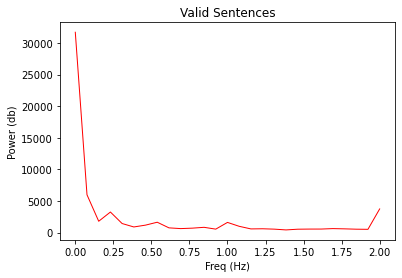

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

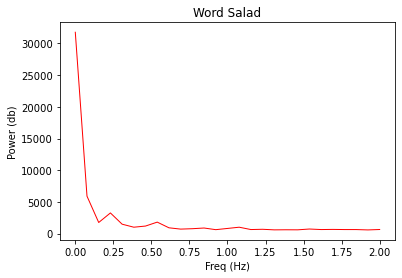

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

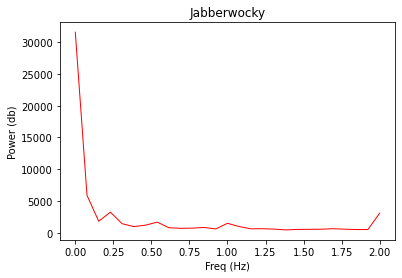

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

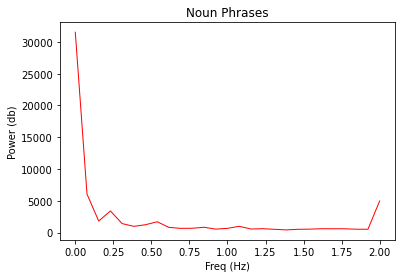

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

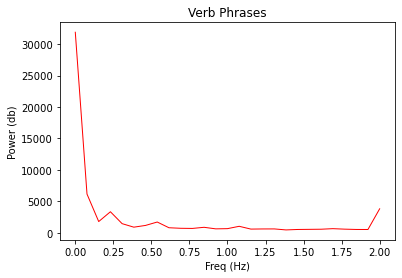

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWar

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:573: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
C:\cb\pytorch_1000000000000\work\aten

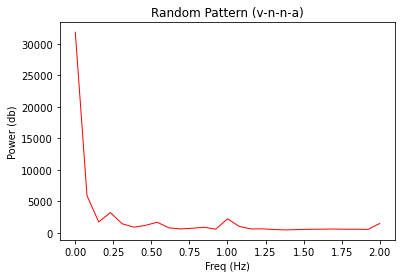

In [24]:
seq_types = ['sen','wordlist','nongrammar','nounphrase','verbphrase','random']
plot_names = {'sen':'Valid Sentences',
             'wordlist':'Word Salad',
             'nongrammar': 'Jabberwocky',
             'nounphrase':'Noun Phrases',
             'verbphrase':'Verb Phrases',
             'random':'Random Pattern (v-n-n-a)'}

data_names = ['freq','mean_power','activations']

n_samples = 13
for i,seq_type in enumerate(seq_types):
    seq_input = gen_data_matrix(seq_type=seq_type)
    mean_powers = []
    all_activations = []
    for seq in seq_input:
        subbatch_sentences = [[(dummy_tag, word) for word in seq]]
        activations = process_sequences(subbatch_sentences)
        all_activations.append(activations)
        freq, mean_power, unit_ps = power_spectra(activations,sampling_rate=4)
        mean_powers.append(mean_power)
    mean_powers = np.mean(np.array(mean_powers),axis=0)
    
    np.save(str(Path(os.getcwd()).parent) + '\\Data\\data-vals-new-datagen\\' + 
             seq_type, np.array(all_activations))
    plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-parser-new-datagen\\' + seq_type,  
             freq, mean_powers,sampling_rate=4,n_samples=1,title=plot_names[seq_type])

(52, 1024)